<a href="https://colab.research.google.com/github/Gibbons-Lab/isb_course_2020/blob/master/16S.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🦠 Amplicon Sequencing Data Analysis with Qiime 2

This notebook will accompany the first session of the 2020 ISB Microbiome Course. The presentation slides can be [found here](https://gibbons-lab.github.io/isb_course_2020/16S). 

Save your own local copy of this notebook by using `File > Save a copy in Drive`. At some point you may be promted to certify the notebook is safe. We promise that it is 🤞

**Disclaimer:**

The Google Colab notebook environment will interpret any command as Python code by default. If we want to run bash commands we will have to prefix them by `!`. So any command you see with a leading `!` is a bash command and if you wanted to run it in your terminal you would omit the leading `!`. For example, if in the Colab notebook you ran `!wget` you would just run `wget` in your terminal. 

## Setup

QIIME 2 is usually installed by following the [official installation instructions](https://docs.qiime2.org/2020.6/install/). However, because we are using Google Colab and there are some caveats to using conda here, we will have to hack around the installation a little bit. But no worries, we provide a setup script below which does all this work for us. 😌 

So...let's start by pulling a local copy of the project repository down from GitHub.

In [1]:
!git clone https://github.com/gibbons-lab/isb_course_2020 materials

Cloning into 'materials'...
remote: Enumerating objects: 998, done.
remote: Total 998 (delta 0), reused 0 (delta 0), pack-reused 998
Receiving objects: 100% (998/998), 172.42 MiB | 31.34 MiB/s, done.
Resolving deltas: 100% (357/357), done.
Checking out files: 100% (1107/1107), done.


Now we are ready to set up our environment. This will take about 10-15 minutes. 

**Note**: This setup is only relevant for Google Colaboratory and will not work on your local machine. Please follow the [official installation instructions](https://docs.qiime2.org/2020.6/install/) for that.

In [2]:
%run materials/setup_qiime2.py

[17:04:59] 🐍 Downloading miniconda...                        setup_qiime2.py:39
[17:05:00] 🐍 Done.                                           setup_qiime2.py:45
           🐍 Installing miniconda...                         setup_qiime2.py:39
[17:05:27] 🐍 Installed miniconda to `/usr/local` 🐍          setup_qiime2.py:45
           🔍 Downloading Qiime 2 package list...             setup_qiime2.py:39
[17:05:28] 🔍 Done.                                           setup_qiime2.py:45
           🔍 Installing Qiime 2. This may take a little bit. setup_qiime2.py:39
            🕐                                                                  
[17:10:56] 🔍 Done.                                           setup_qiime2.py:45
           🔍 Fixed import paths to include Qiime 2.          setup_qiime2.py:93
           📊 Checking that Qiime 2 command line works...     setup_qiime2.py:39
[17:11:01] 📊 Qiime 2 command line looks good 🎉              setup_qiime2.py:45
           📊 Checking if Qiime 2 import wo

We will switch to working within the `materials` directory for the rest of the notebook.

In [3]:
%cd materials

/content/materials


## Our first QIIME 2 command

Let's remember our workflow for today.

![our workflow](https://github.com/Gibbons-Lab/isb_course_2020/raw/master/docs/16S/assets/steps.png)

The first thing we have to do is to get the data into an artifact.
We can import the data with the `import` action from the tools. For that we have to give
QIIME 2 a *manifest* (list of raw files) and tell it what *type of data* we
are importing and what *type of artifact* we want. 

**QoL Tip:** QIIME 2 commands can get very long. To split them up over several lines we can use `\` which means "continue on the next line".

In [4]:
!qiime tools import \
  --type 'SampleData[SequencesWithQuality]' \
  --input-path manifest.tsv \
  --output-path cdiff.qza \
  --input-format SingleEndFastqManifestPhred33V2

Imported manifest.tsv as SingleEndFastqManifestPhred33V2 to cdiff.qza


Since we have quality information for the sequencing reads, let's also generate
our first visualization to inspect sequence quality. 

---

Qiime 2 commands can become pretty long. Here some pointers to remember the
structure of a command:

```
qiime plugin action --i-argument1 ... --o-argument2 ...
```

Argument types usually begin with a letter denoting their meaning:

- `--i-...` = input files
- `--o-...` = output files
- `--p-...` = parameters
- `--m-...` = metadata

---

In this case we will use the `summarize` action from the `demux` plugin with the previously generated artifact as input and output the resulting visualization to the `qualities.qzv` file.

In [5]:
!qiime demux summarize --i-data cdiff.qza --o-visualization qualities.qzv

Saved Visualization to: qualities.qzv


You can view the plot by downloading the .qzv file and opening it using http://view.qiime2.org. To download click on the folder symbol to the left, open the `materials` folder, and choose download from the dot menu next to the file.

🤔 What do you observe across the read? Where would you truncate the reads?

# Denoising amplicon sequence variants

We will now run the DADA2 plugin which will do 3 things:

1. filter and trim the reads
2. find the most likely set of unique sequences in the sample (ASVs)
3. remove chimeras
4. count the abundances of each ASV


Since this step takes a bit, let's start the process and use the time to
understand what is happening:

In [6]:
!qiime dada2 denoise-single \
    --i-demultiplexed-seqs cdiff.qza \
    --p-trunc-len 150 \
    --output-dir dada2 --verbose

Running external command line application(s). This may print messages to stdout and/or stderr.
The command(s) being run are below. These commands cannot be manually re-run as they will depend on temporary files that no longer exist.

Command: run_dada_single.R /tmp/qiime2-archive-jllpwokq/81e87be9-308c-4897-b73f-62d7279a4570/data /tmp/tmp0s7buw65/output.tsv.biom /tmp/tmp0s7buw65/track.tsv /tmp/tmp0s7buw65 150 0 2.0 2 Inf independent consensus 1.0 1 1000000 NULL 16

R version 3.5.1 (2018-07-02) 
Loading required package: Rcpp
DADA2: 1.10.0 / Rcpp: 1.0.4.6 / RcppParallel: 5.0.0 
1) Filtering ........
2) Learning Error Rates
79415850 total bases in 529439 reads from 8 samples will be used for learning the error rates.
3) Denoise samples ........
4) Remove chimeras (method = consensus)
5) Report read numbers through the pipeline
6) Write output
Saved FeatureTable[Frequency] to: dada2/table.qza
Saved FeatureData[Sequence] to: dada2/representative_sequences.qza
Saved SampleData[DADA2Stats] t

If this step takes too long or fails, you can also copy the results from the treasure chest. *However, don't run the next cell if this cell completes successfully.*

In [7]:
# only run if the previous cell did not work
!cp -r treasure_chest/dada2 .

Ok, this step ran, but we should also make sure it kind of worked. One good way to tell if the identified ASVs are represnetative of the sample is to see how mant reads were maintained throughout the pipeline. Here, the most common issues and solutions are:

**Large fraction of reads is lost during merging (only paired-end)**

![read overlap](https://gibbons-lab.github.io/isb_course_2020/16S/assets/read_overlap.png)

In order to merge ASVs DADA2 uses an overlap of 12 bases between forward and reverse reads by default. Thus, your reads must allow for sufficient overlap *after* trimming. So if your amplified region is 450bp long and you have 2x250bp reads and you trim the last 30 bases of each read, truncating the length to 220bp, the total length of covered sequence is 2x220 = 440 which is shorter than 450bp so there will be no overlap. To solve this issue trim less of the reads or adjust the `--p-min-overlap` parameters to something lower (but not too low).

<br>

**Most of the reads are lost as chimeric**

![read overlap](https://gibbons-lab.github.io/isb_course_2020/16S/assets/chimera.png)

This is usualluy an experimental issue as chimeras are introduced during amplification. If you can adjust your PCR, try to run fewer cycles. Chimeras can also be introduced by incorrect merging. If your minimum overlap is too small ASVs may be merged randomly. Possible fixes are to increase the `--p-min-overlap` parameter or run the analysis on the forward reads only (in our empirical observations, chimeras are more likely to be introduced in the joined reads). *However, losing between 5-25% of your reads to chimeras is normal and does not require any adjustments.*

Our denoising stats are contained in an artifact. To convert it to a visualization we can use `qiime metadata tabulate`.

In [8]:
!qiime metadata tabulate \
    --m-input-file dada2/denoising_stats.qza \
    --o-visualization dada2/denoising-stats.qzv

Saved Visualization to: dada2/denoising-stats.qzv


What proprotion of reeads was retained throughout the entire pipeline? Look at the final number of used reads (non-chimeric). What do you observe when comparing those values between samples and how might that affect diversity metrics?

# Phylogeny and diversity

## Building a tree

We can build a phylogenetic tree for our sequences using the following command:

In [9]:
!qiime phylogeny align-to-tree-mafft-fasttree \
    --i-sequences dada2/representative_sequences.qza \
    --output-dir tree

Saved FeatureData[AlignedSequence] to: tree/alignment.qza
Saved FeatureData[AlignedSequence] to: tree/masked_alignment.qza
Saved Phylogeny[Unrooted] to: tree/tree.qza
Saved Phylogeny[Rooted] to: tree/rooted_tree.qza


You can visualize your tree using iTOL (https://itol.embl.de/). Open iTol and upload the artifact from `materials/tree/tree.qza`.

This looks nice but is not particularly informative as is. The main utility of our tree will be in complementing our diversity analyses. It will tell us which ASVs are more or less related to one another, which will allow us to calculate different kinds of ecological diversity metrics.

## Alpha and Beta Diversity

Qiime 2 has "run-all" command for diversity analyses. This will

1. Subsampe our samples to the same total number of reads (Why?) 
2. Calculate alpha and beta diversity measures
3. Visualize PCoA projections

In [10]:
!qiime diversity core-metrics-phylogenetic \
    --i-table dada2/table.qza \
    --i-phylogeny tree/rooted_tree.qza \
    --p-sampling-depth 8000 \
    --m-metadata-file metadata.tsv \
    --output-dir diversity

Saved FeatureTable[Frequency] to: diversity/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: diversity/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: diversity/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: diversity/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: diversity/evenness_vector.qza
Saved DistanceMatrix to: diversity/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: diversity/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: diversity/jaccard_distance_matrix.qza
Saved DistanceMatrix to: diversity/bray_curtis_distance_matrix.qza
Saved PCoAResults to: diversity/unweighted_unifrac_pcoa_results.qza
Saved PCoAResults to: diversity/weighted_unifrac_pcoa_results.qza
Saved PCoAResults to: diversity/jaccard_pcoa_results.qza
Saved PCoAResults to: diversity/bray_curtis_pcoa_results.qza
Saved Visualization to: diversity/unweighted_unifrac_emperor.qzv
Saved Visualization to: diversity/weighted_unifrac_emperor.qzv
Saved

## Statistical analyses

Let's first have a look at alpha diversity. Can we see a difference in the per-sample diversity between healthy and sick individuals?

In [11]:
!qiime diversity alpha-group-significance \
    --i-alpha-diversity diversity/shannon_vector.qza \
    --m-metadata-file metadata.tsv \
    --o-visualization diversity/alpha_groups.qzv

Saved Visualization to: diversity/alpha_groups.qzv


Now, let's use beta diversity to see how different the samples are from one another. First download `diversity/weighted_unifrac_emperor.qzv` and take a look. Do samples separate based on disease state? 

We can check whether that separation is 'significant' by using a PERMANOVA test.

In [12]:
!qiime diversity adonis \
    --i-distance-matrix diversity/weighted_unifrac_distance_matrix.qza \
    --m-metadata-file metadata.tsv \
    --p-formula "disease_stat" \
    --p-n-jobs 2 \
    --o-visualization permanova.qzv

Saved Visualization to: permanova.qzv


# Taxonomy

We will use a Bayes classifier trained on the GreenGenes database which can be downloaded from https://docs.qiime2.org/2020.6/data-resources/.

In [13]:
!wget https://data.qiime2.org/2020.8/common/gg-13-8-99-515-806-nb-classifier.qza

--2020-10-08 17:18:38--  https://data.qiime2.org/2020.8/common/gg-13-8-99-515-806-nb-classifier.qza
Resolving data.qiime2.org (data.qiime2.org)... 52.35.38.247
Connecting to data.qiime2.org (data.qiime2.org)|52.35.38.247|:443... connected.
HTTP request sent, awaiting response... 302 FOUND
Location: https://s3-us-west-2.amazonaws.com/qiime2-data/2020.8/common/gg-13-8-99-515-806-nb-classifier.qza [following]
--2020-10-08 17:18:39--  https://s3-us-west-2.amazonaws.com/qiime2-data/2020.8/common/gg-13-8-99-515-806-nb-classifier.qza
Resolving s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)... 52.218.242.48
Connecting to s3-us-west-2.amazonaws.com (s3-us-west-2.amazonaws.com)|52.218.242.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 28285585 (27M) [binary/octet-stream]
Saving to: ‘gg-13-8-99-515-806-nb-classifier.qza’

gg-13-8-99-515-806- 100%[===================>]  26.97M  21.3MB/s    in 1.3s    

2020-10-08 17:18:40 (21.3 MB/s) - ‘gg-13-8-99-515-806-nb-

In [14]:
!qiime feature-classifier classify-sklearn \
    --i-reads dada2/representative_sequences.qza \
    --i-classifier gg-13-8-99-515-806-nb-classifier.qza \
    --o-classification taxa.qza

Saved FeatureData[Taxonomy] to: taxa.qza


Now let's have a look at the relative abundances of the different bacterial taxa we have in each sample:

In [15]:
!qiime taxa barplot \
    --i-table dada2/table.qza \
    --i-taxonomy taxa.qza \
    --m-metadata-file metadata.tsv \
    --o-visualization taxa_barplot.qzv

Saved Visualization to: taxa_barplot.qzv


We can also collapse data on a particular taxonomic rank using the QIIME 2 [taxa plugin](https://docs.qiime2.org/2020.6/plugins/available/taxa/). Why might we want to look at different taxonomic ranks, rather than just looking at ASVs?

In [16]:
!qiime taxa collapse \
    --i-table dada2/table.qza \
    --i-taxonomy taxa.qza \
    --p-level 6 \
    --o-collapsed-table genus.qza

Saved FeatureTable[Frequency] to: genus.qza


We can export the table and convert it to a .csv file so that we can analyze these data using tools outside of the QIIME 2 environment.

In [17]:
!qiime tools export \
    --input-path genus.qza \
    --output-path exported
!biom convert -i exported/feature-table.biom -o genus.tsv --to-tsv

Exported genus.qza as BIOMV210DirFmt to directory exported


Now the data are in a common format and we can use them, for instance, to draw a heatmap using Pandas and Seaborn.

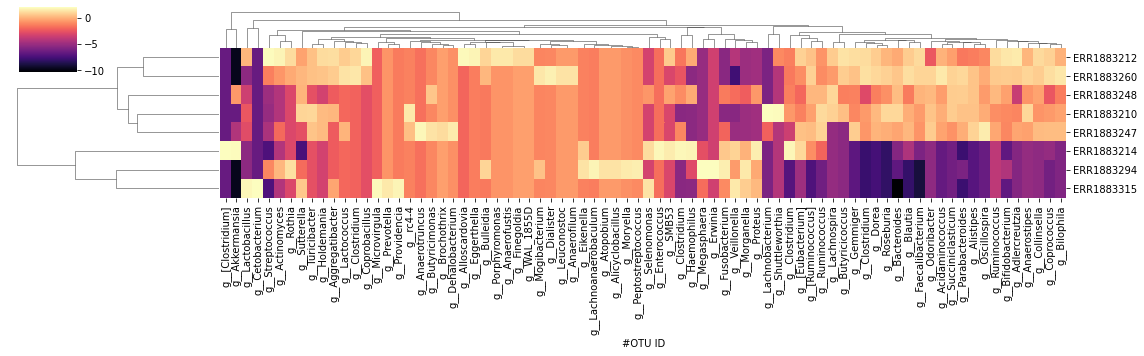

In [18]:
import numpy as np
import pandas as pd
import seaborn as sns

abundances = pd.read_table("genus.tsv", skiprows=1, index_col=0)
abundances.index = abundances.index.str.split(";").str[5]  # Use only the genus name
abundances = abundances[~abundances.index.isin(["g__", "__"])]  # remove unclassified genera

# Let's do a centered log-ratio transform: log x_i - log mean(x)
transformed = abundances.apply(
    lambda xs: np.log(xs + 0.5) - np.log(xs.mean() + 0.5),
    axis=1)

sns.clustermap(transformed.T, cmap="magma", xticklabels=True, figsize=(16, 5))

# Exercises

Okay, that's enough time in the back seat. 

It's time to take the wheel 🚗 

Now you can dive into the data 🏊

## Exercise 1 - Sample Classification

One pretty basic question we can ask is whether the microbial composition in the gut is predictive of recurrent *C. difficile* infection. 
Could you predict if someone had a recurrent infection from 16S data alone?

Let's check with the genus-level data and use the QIIME 2 [sample-classifier plugin](https://docs.qiime2.org/2020.6/plugins/available/sample-classifier). 

Start with the `classfiy-samples` action and follow it up with the `heatmap` afterwards to visualize important genera.

In [19]:
# Your code here

## Exercise 2 - Plant a Tree

One visualizatuon that we did not spend a lot of time on was the phylogentic tree of our ASVs. Let's change that! 

First, annotate the tree with taxonomy by going back to the tree and adding the predicted taxa (`taxa.qza`) using the `+` button on the lower right. 

Also add your feature table, but don't use the raw one (why?). Rather, use `diversity/rarefied_table.qza` where each sample has been subsampled to 10000 reads (why?). 

What other normalization methods could you use?

What do you observe?

In [20]:
# Your code here